In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['online-news-popularity-dataset']
/kaggle/input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv


# 1. KNN

#### Dowloaded data. Target variable is shares, issue is regression

In [2]:
df = pd.read_csv("../input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv")
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2014/09/28/jobs-tech-workers/,101,12,332,0.528481,1.0,0.645833,6,3,1,...,0.100000,0.7,-0.145833,-0.166667,-0.125000,0.718182,0.137121,0.218182,0.137121,8600
1,http://mashable.com/2014/09/28/obama-says-u-s-...,101,10,393,0.518817,1.0,0.596899,14,1,1,...,0.250000,0.8,-0.312500,-0.500000,-0.250000,0.500000,0.000000,0.000000,0.000000,23700
2,http://mashable.com/2014/09/28/once-upon-a-tim...,101,13,1643,0.388854,1.0,0.546967,29,4,7,...,0.033333,0.8,-0.227778,-0.800000,-0.050000,0.000000,0.000000,0.500000,0.000000,8400
3,http://mashable.com/2014/09/28/the-simpsons-de...,101,9,272,0.488889,1.0,0.512690,2,2,11,...,0.100000,1.0,-0.416667,-1.000000,-0.166667,0.000000,0.000000,0.500000,0.000000,4800
4,http://mashable.com/2014/09/28/viola-davis-les...,101,12,0,0.000000,0.0,0.000000,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.541071,0.067560,0.041071,0.067560,3100


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4954 non-null   object 
 1   timedelta                      4954 non-null   int64  
 2   n_tokens_title                 4954 non-null   int64  
 3   n_tokens_content               4954 non-null   int64  
 4   n_unique_tokens                4954 non-null   float64
 5   n_non_stop_words               4954 non-null   float64
 6   n_non_stop_unique_tokens       4954 non-null   float64
 7   num_hrefs                      4954 non-null   int64  
 8   num_self_hrefs                 4954 non-null   int64  
 9   num_imgs                       4954 non-null   int64  
 10  num_videos                     4954 non-null   int64  
 11  average_token_length           4954 non-null   float64
 12  num_keywords                   4954 non-null   i

#### This looks like exponential distribution.

(0.0, 20000.0)

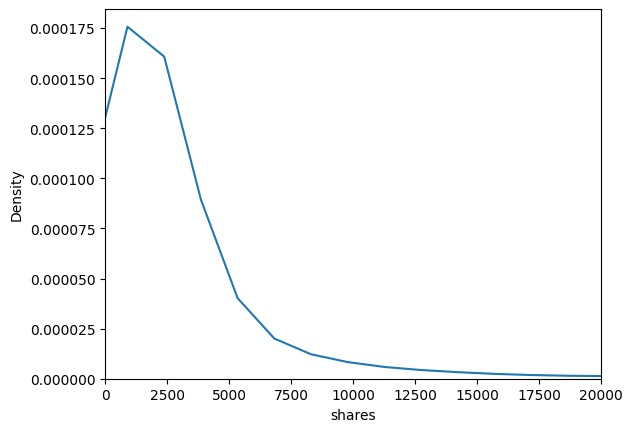

In [4]:
sns.kdeplot(df['shares'])
plt.xlim(0, 20000)

#### Preproccessing is almost already done. Lets make shares more demonstrative. Now we have tagret variable ```is_popular``` that says if article have more than 2500 shares article is popular. And now we have issue classification. We will drop column `share`, because this column misrepresent our model. 

In [5]:
df['is_popular'] = (df['shares'] > 2500).astype(int)
df.drop(columns=['shares'], axis=1, inplace=True)
df['is_popular'].value_counts()

is_popular
0    3622
1    1332
Name: count, dtype: int64

In [6]:
df.drop(columns=['url'], axis=1, inplace=True)

#### Now let`s split and normalize data 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df.drop('is_popular', axis=1)
X = scaler.fit_transform(X)
y = df['is_popular']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=4)

#### And let`s train our model and evaluate the quality of predictions for our hyperparameter.

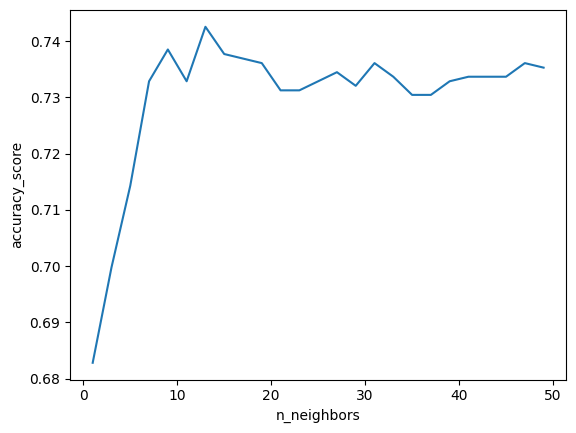

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
accuracy_scores = []
for k in range(1, 50, 2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_valid)
  acc = accuracy_score(y_valid, y_pred)
  accuracy_scores.append(acc)

plt.plot(list(range(1, 50, 2)), accuracy_scores)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy_score')
plt.show()

We can see that result almost the same after `k=13` and have accuracy 74%.

# 2. Setting the optimal number of nearest neighbors in the method kNN

Now lets try cross validation with 5 splits.

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross = kf.split(X)
knn_grid = GridSearchCV(knn, {'n_neighbors': np.arange(1, 50, 2), 'p': [1]}, scoring='accuracy', cv = cross)
knn_grid.fit(X, y)
print("Best params: ", knn_grid.best_params_, "; with best accuracy: ", knn_grid.best_score_)

Best params:  {'n_neighbors': 27, 'p': 1} ; with best accuracy:  0.7404099521960269


We can see that `k=27` have the best result with best accuracy 74.0%. 

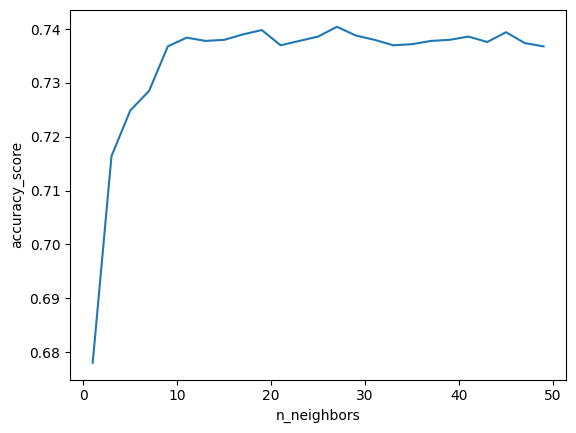

In [10]:
plt.plot(list(range(1, 50, 2)), knn_grid.cv_results_['mean_test_score'])
plt.xlabel('n_neighbors')
plt.ylabel('accuracy_score')
plt.show()

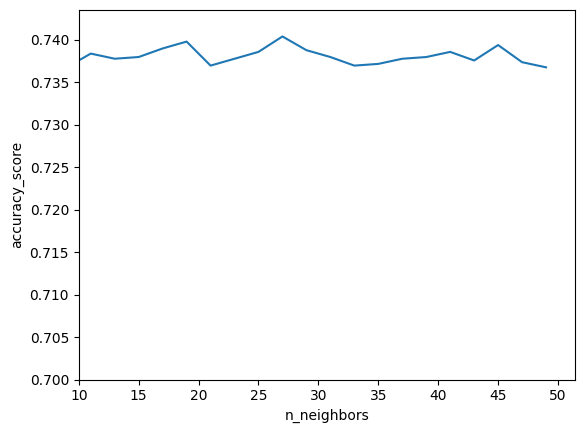

In [11]:
plt.plot(list(range(1, 50, 2)), knn_grid.cv_results_['mean_test_score'])
plt.xlabel('n_neighbors')
plt.ylabel('accuracy_score')
plt.xlim(10)
plt.ylim(0.7)
plt.show()

So we can take `k=27` or, for example, `k=21`.

# 3. Selection of the metric in the method kNN

Lets find `p` for `k=27` and `k=21`. 

In [12]:
from sklearn.model_selection import cross_val_score
def mean(l):
    sum = 0
    for i in l:
        sum += i
    return sum/len(l)
accuracy_scoresfor27 = []
param_ps = np.linspace(1, 10, 20)
for p in param_ps:
  knn = KNeighborsClassifier(n_neighbors=27, p=p, weights='distance')
  acc = mean( cross_val_score(knn, X, y, cv=5, scoring="accuracy") )
  accuracy_scoresfor27.append(acc)


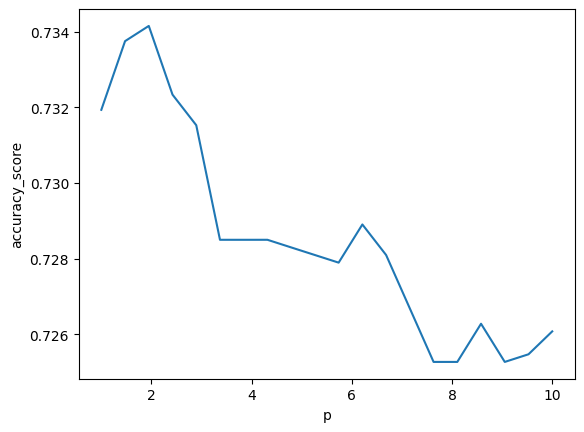

In [13]:
plt.plot(param_ps, accuracy_scoresfor27)
plt.xlabel('p')
plt.ylabel('accuracy_score')
plt.show()

In [14]:
print("accuracy for k=27:", max(accuracy_scores))

accuracy for k=27: 0.7425343018563357


In [15]:
accuracy_scoresfor30 = []
param_ps = np.linspace(1, 10, 20)
for p in param_ps:
  knn = KNeighborsClassifier(n_neighbors=21, p=p, weights='distance')
  acc = mean( cross_val_score(knn, X, y, cv=5, scoring="accuracy") )
  accuracy_scoresfor30.append(acc)

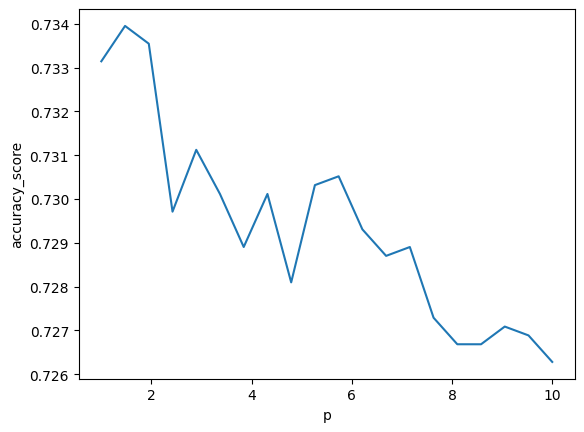

In [16]:
plt.plot(param_ps, accuracy_scoresfor30)
plt.xlabel('p')
plt.ylabel('accuracy_score')
plt.show()

In [17]:
print("accuracy for k=21:", max(accuracy_scoresfor30))

accuracy for k=21: 0.7339532560723278


We can see that with `k=27` and `p=3.8421052631578947` (74.25%) we have better result than the best result `k=21` and `p=1.4736842105263157` (73.39%)

# 4. Test another metric

Let test `NearestCentroid` with hyperparamet `metric`

In [18]:
from sklearn.neighbors import NearestCentroid

nc = NearestCentroid()

kf = KFold(n_splits=5, shuffle=True, random_state=29) 
scores = cross_val_score(nc, X, y, cv=kf, scoring='accuracy')

print('Accuracy score:', np.mean(scores))

Accuracy score: 0.681470813075253


Lets try manhatam metric

In [19]:
from sklearn.neighbors import NearestCentroid

nc = NearestCentroid(metric='manhattan')

kf = KFold(n_splits=5, shuffle=True, random_state=29) 
scores = cross_val_score(nc, X, y, cv=kf, scoring='accuracy')

print('Accuracy score:', np.mean(scores))

Accuracy score: 0.6360490882589773


We have that manhattan metric worse result than euclidean. And have worse result for KNN